In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)
#matplotlib.style.use('seaborn-darkgrid')

In [3]:

# busca o histórico de movimentação na conta da b3
b3 = pd.read_excel("movimentação B3.xlsx")

# Somente acoes
def acoes(b3):
    acoes = b3[(b3['Tipo de Ativo']=="AÇÃO")]
    return acoes

def fii(b3):
    fii = b3[(b3['Tipo de Ativo']=="FII") 
             & (b3['Papel']!="MXRF12")]
    return fii

def total(b3):
    total = b3[(b3['Papel']!="MXRF12")]
    return total

def carteira_atual(b3):
    resultado = b3.groupby(['Tipo de Ativo', 'Papel']).agg({'QTD': 'sum', 'Patrimonio liquido': 'sum'}).reset_index()
    resultado = resultado[resultado['QTD'] != 0]
    
    papel = resultado['Papel']+'.SA'
    preco = []
    for x in papel:
        stock = yf.Ticker(x)
        quote_data = stock.info
        valor = quote_data['regularMarketPreviousClose']
        preco.append(valor)
    resultado["Patrimônio atual"] = preco * resultado['QTD']

    return resultado

def proventos

#Carteira cotizada
def carteira_cotizada(b3):
        
    #filtra apenas a movimentação das ações
    b3_a = b3[(b3['Tipo Movimentação']=="Movimentação")]
    b3_p = b3[(b3['Tipo Movimentação']=="Provento")]
    
    #filtro das colunas necessárias
    b3_a = b3_a[['Data', 'Papel', 'QTD', 'Preço unitário']]
    b3_p = b3_p[['Data', 'Valor da Operação']]
    b3_p = b3_p.set_index('Data')
    b3_p = b3_p['Valor da Operação']
    
    b3_a = b3_a[b3_a['Papel'] != 'ENBR3']
    
    
    #transforma as ações em colunas com as quantidades como valores base
    trade_quant = pd.pivot_table(b3_a, values='QTD', index=['Data'], columns=b3_a['Papel'], aggfunc=np.sum, fill_value=0)
    
    #transforma as ações em colunas com os preços como valores base
    trade_preco = pd.pivot_table(b3_a, values='Preço unitário', index=['Data'], columns=b3_a['Papel'], fill_value=0)
    
    #Baixar cotação dos ativos
    precos = yf.download(tickers=(trade_quant.columns+'.SA').to_list(),start=trade_quant.index[0], rounding=True)['Adj Close']
    
    # tirando o .SA
    precos.columns = precos.columns.str.rstrip('.SA')

    #remove valores vazios do dataframe pelo valor anterior
    for x in precos.columns:
        precos[x] = precos[x].fillna(method='ffill')
    
    # reestrutura as linhas do DF trade_quant para todos os dias de operação do DF precos
    trades = trade_quant.reindex(index=precos.index)
    trades.fillna(value=0, inplace=True)      
    
    #provento_recebido = b3_p.reindex(index=precos.index)
    #provento_recebido.fillna(value=0, inplace=True)
    
    #calcula os aportes em uma coluna
    aportes = (trades * trade_preco).sum(axis=1)
    
    # calcula as posições em forma acumulativa
    posicao = trades.cumsum()
    
    
    # calcula o patrimômino investido e Saldo da carteira
    carteira = posicao * precos
    carteira['Saldo'] = carteira.sum(axis=1)
    carteira['Patrimônio Investido'] = aportes.cumsum()
    
    #calcula lucro projetado com base no valor investido e variação da cota
    carteira['Lucro'] = carteira['Saldo'] - carteira['Patrimônio Investido']
    #carteira['Proventos'] = provento_recebido
    
    #Calcula o valor da cota da carteira, quantidade e rentabilidade
    for i, data in enumerate(aportes.index):
        if i == 0:
            carteira.at[data, 'vl_cota'] = 1
            carteira.at[data, 'qtd_cotas'] = carteira.loc[data]['Saldo'].copy()
        else:
            if aportes[data] != 0:
                carteira.at[data, 'qtd_cotas'] = carteira.iloc[i-1]['qtd_cotas'] + (aportes[data] / carteira.iloc[i-1]['vl_cota'])
                carteira.at[data, 'vl_cota'] = carteira.iloc[i]['Saldo'] / carteira.at[data, 'qtd_cotas']                
            else:
                carteira.at[data, 'qtd_cotas'] = carteira.iloc[i-1]['qtd_cotas']
                carteira.at[data, 'vl_cota'] = carteira.iloc[i]['Saldo'] / carteira.at[data, 'qtd_cotas']
                    
    carteira['Rentabilidade'] = carteira['vl_cota'].pct_change()
    
    return carteira

In [4]:
cart_atual = carteira_atual(total(b3))

cart_cot_a = carteira_cotizada(acoes(b3))
cart_cot_f = carteira_cotizada(fii(b3))
cart_cot = carteira_cotizada(total(b3))

[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  47 of 47 completed


In [7]:
cart_atual.to_excel('0 - Carteira_Atual.xlsx')
cart_cot.to_excel('0 - Carteira_Cotizada.xlsx')
cart_cot_a.to_excel('0 - Carteira_Cotizada_Ações.xlsx')
cart_cot_f.to_excel('0 - Carteira_Cotizada_Fii.xlsx')

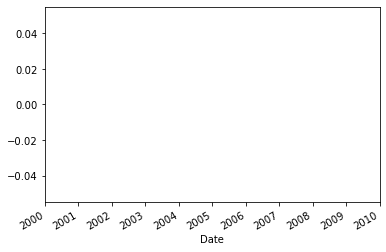

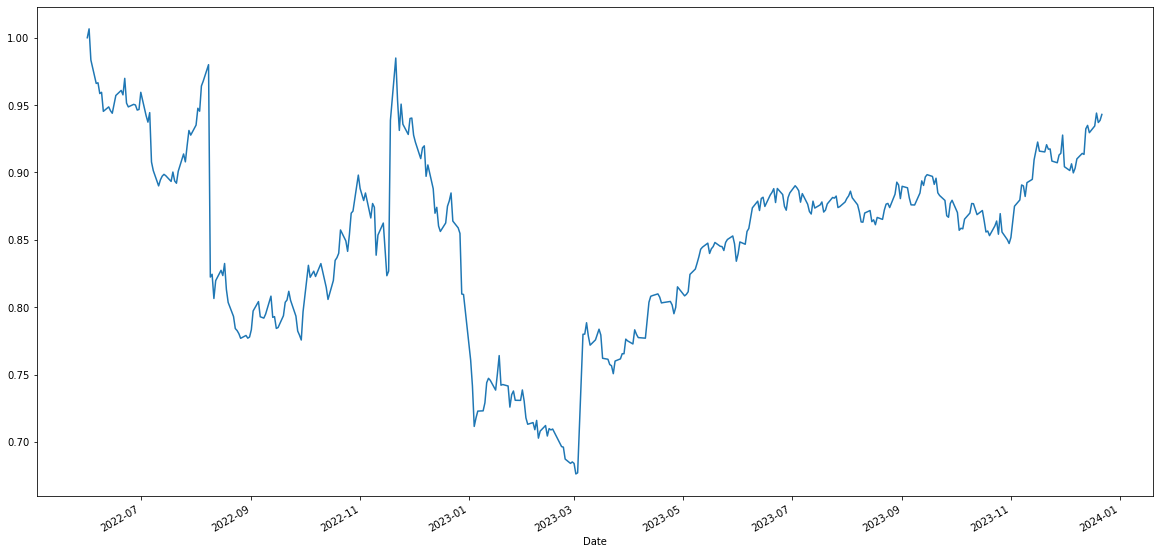

In [44]:
cart['vl_cota'].plot();

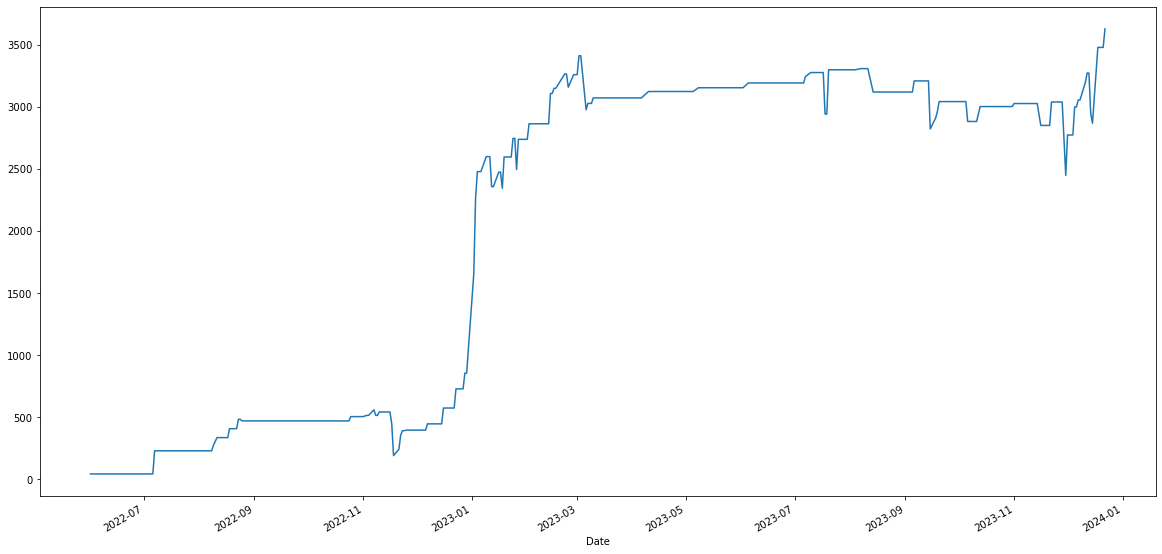

In [45]:
cart['qtd_cotas'].plot();

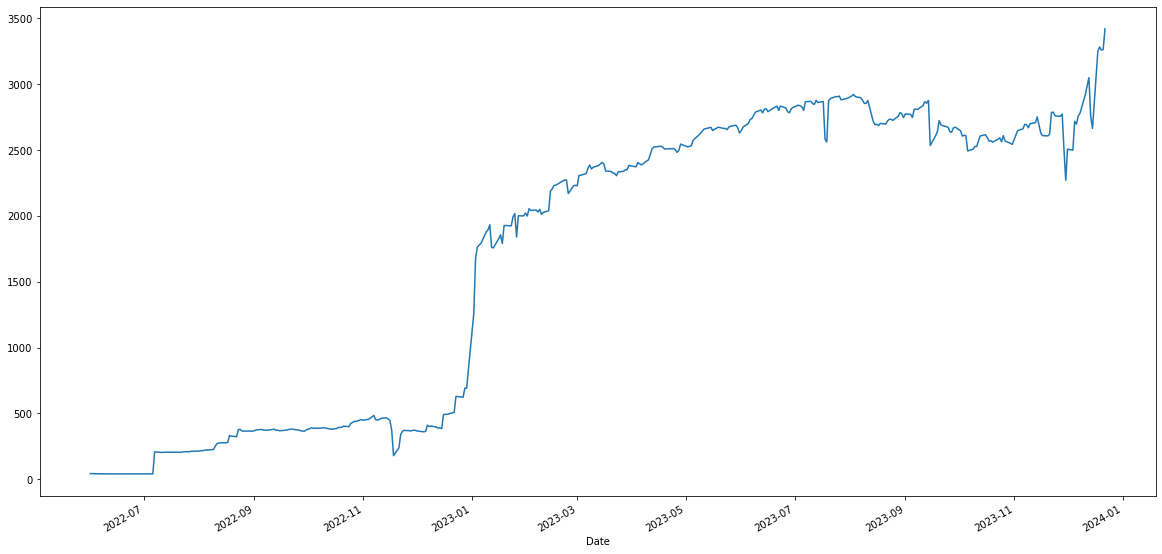

In [46]:
cart['Saldo'].plot();

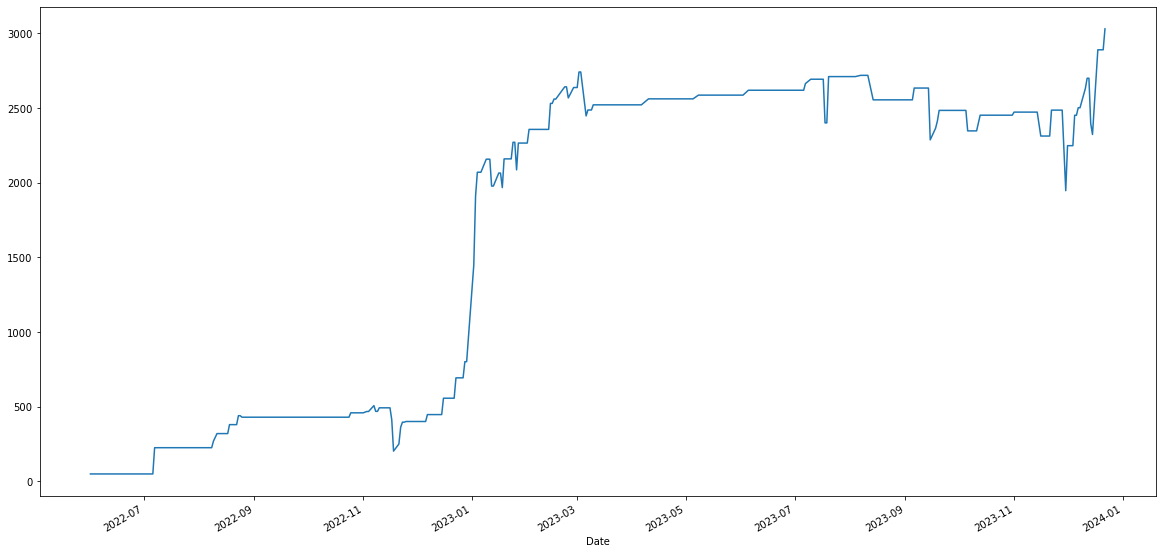

In [47]:
cart['Patrimônio Investido'].plot();

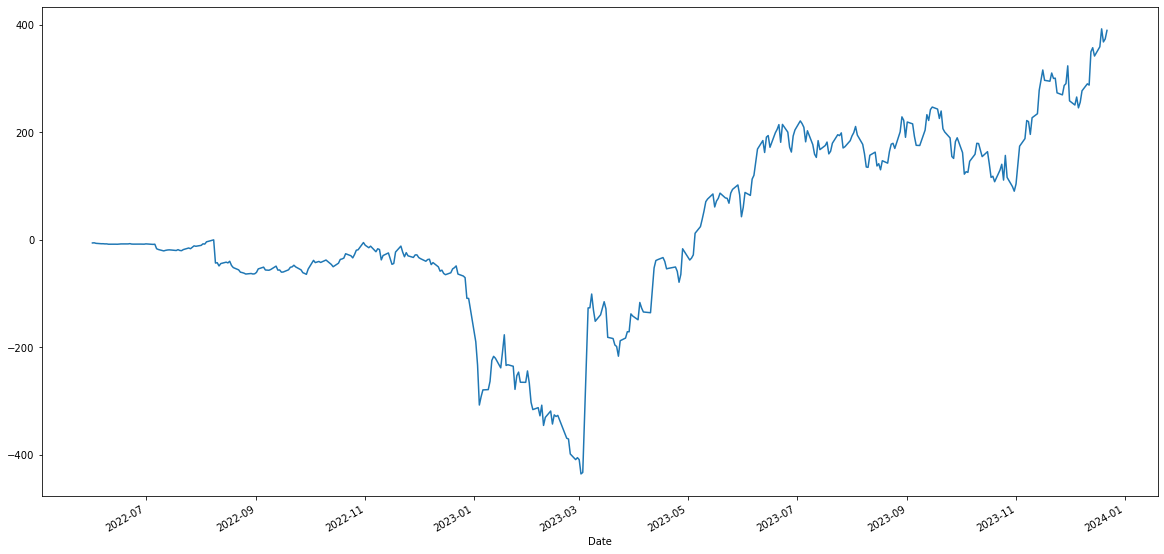

In [48]:
cart['Lucro'].plot();